This is my first in-depth analysis of time series data. We will use a technique called ARIMA and we will also be relying on <a href=https://builtin.com/data-science/time-series-python> this article </a> as our source.

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv("./data/archive/AirPassengers.csv")

In [24]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Preprocessing

In [29]:
df.rename(columns={'Passengers' : 'Passengers'}, inplace=True)

In [30]:
# To datetime object
df.Month = pd.to_datetime(df.Month)

In [31]:
# Make datetime into index
df = df.set_index(df.Month).drop(columns='Month')

## Visualization

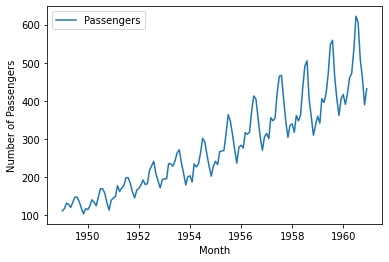

In [32]:
sns.lineplot(df)
plt.ylabel("Number of Passengers")
plt.show()

# Points of Note
Before we begin our forecasts we need to keep in mind a couple of things, as per our source

## Stationarity
> Simply put, stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. You should check for stationarity because it not only makes modeling time series easier, but it is an underlying assumption in many time series methods.

In [33]:
rolling_mean = df.rolling(7).mean()
rolling_std = df.rolling(7).std()

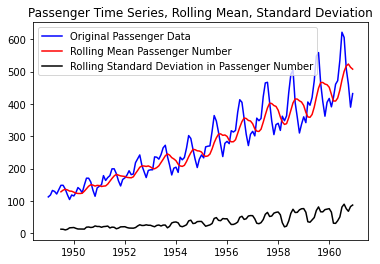

In [34]:
# Plotting rolling std and mean superimposed on original plot
plt.plot(df, color="blue",label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()

### Dickey-Fuller test
Here we are testing for the null hypothesis, that there is no stationarity. The documentation <a href=https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html> here </a> puts it more formally:
> The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

In [35]:
from statsmodels.tsa.stattools import adfuller

In [36]:
# Autolag chosen to minimize the information criterion
adft = adfuller(df,autolag="AIC")

In [37]:
# Displaying our results as a dataframe
output_df = pd.DataFrame({"Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"], "Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]})
print(output_df)

                        Metric      Values
0              Test Statistics    0.815369
1                      p-value    0.991880
2             No. of lags used   13.000000
3  Number of observations used  130.000000
4          critical value (1%)   -3.481682
5          critical value (5%)   -2.884042
6         critical value (10%)   -2.578770


### Conclusion
Our p-value is way greater than .05 and so we fail to reject the null hypothesis, that there is no stationarity.

## Autocorrelation
> This is a measure of how correlated time series data is at a given point in time with past values, which has huge implications across many industries. 

In [43]:
# For one, three, six and nine months
autocorrelation_lag1 = df.Passengers.autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df.Passengers.autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df.Passengers.autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df.Passengers.autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.9601946480498523
Three Month Lag:  0.837394765081794
Six Month Lag:  0.7839187959206183
Nine Month Lag:  0.8278519011167601


### Conclusion
> We see that, even with a nine-month lag, the data is highly autocorrelated. This is further illustration of the short- and long-term trends in the data.

## Decomposition

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

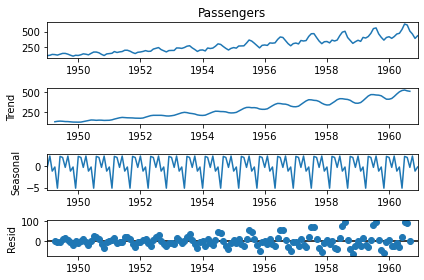

In [45]:
decompose = seasonal_decompose(df.Passengers, model="additive", period=7)
decompose.plot()
plt.show()

### Conclusion
From this plot, we can clearly see the increasing trend in number of passengers and the seasonality patterns in the rise and fall in values each year.

## Forecasting
We will be using the `auto_arima` function from the package `pmdarima`. This will eliminate the need for highly laborious hyperparameter tuning.

In [51]:
from pmdarima.arima import auto_arima

### Test Train Split

In [48]:
df['Date'] = df.index
train = df[df['Date'] < pd.to_datetime("1960-08", format='%Y-%m')]
train['train'] = train['Passengers']
del train['Date']
del train['Passengers']
test = df[df['Date'] >= pd.to_datetime("1960-08", format='%Y-%m')]
del test['Date']
test['test'] = test['Passengers']
del test['Passengers']

C:\Users\USER\AppData\Local\Temp\ipykernel_9920\1750339779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['Passengers']
C:\Users\USER\AppData\Local\Temp\ipykernel_9920\1750339779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['Passengers']


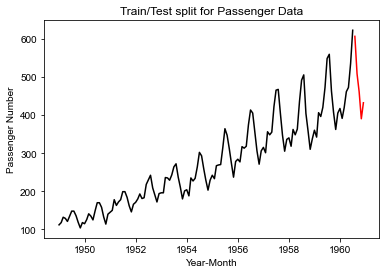

In [49]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [52]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

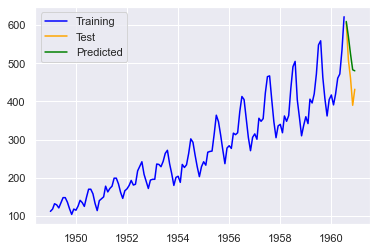

In [61]:
plt.plot(train, color="blue", label="Training")
plt.plot(test, color="orange", label="Test")
plt.plot(forecast, color="green", label="Predicted")
plt.legend(loc="best")
plt.show()

### RMSE

In [55]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [56]:
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  61.363269137815635
